# Ethereum Blockchain Explorer
Some functions to help explore the ethereum blockchain using JSON RPC on the BlockScience geth node

In [1]:
import requests, json
import pandas as pd
import numpy as np
SESSION = requests.Session()
f = open("bs_node_ip.txt","r")
RPC_HOST = f.readline()
RPC_HOST = str.replace(RPC_HOST,'\n','')
RPC_PORT = '8545'
RPC_URL = 'http://'+RPC_HOST+':'+RPC_PORT

## Basic JSON downloading

In [2]:
def getJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    response = json.loads(json_data)
    return response

In [3]:
def getRawJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    return json_data

In [4]:
# test if the getJSON function supports GET requests
# getJSON('https://api.etherscan.io/api?module=account&action=balance&address=0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae&tag=latest&apikey=YourApiKeyToken')

In [5]:
# test if the getJSON function supports POST requests
# getJSON(RPC_URL,'{"jsonrpc":"2.0","method":"eth_syncing","params":[],"id":1}')

## Consensys EthJsonRpc Package

I wasn't able to quickly make the package work on Python 3

In [6]:
# from ethjsonrpc import EthJsonRpc
# c = EthJsonRpc('35.196.250.157', 8545)
# print(c.net_version())
# print(c.web3_clientVersion())
# print(c.eth_gasPrice())

So I began copying their functions. Most of them still need testing. Ideally we should fork and make our own package compatible with Python 3

In [7]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def hex_to_dec(x):
    '''
    Convert hex to decimal
    '''
    return int(x, 16)

In [8]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def clean_hex(d):
    '''
    Convert decimal to hex and remove the "L" suffix that is appended to large
    numbers
    '''
    return hex(d).rstrip('L')

In [9]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def validate_block(block):
#     doesn't work on Python 3
#     if isinstance(block, basestring):
#         if block not in BLOCK_TAGS:
#             raise ValueError('invalid block tag')
    if isinstance(block, int):
        block = hex(block)
    return block

In [10]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def wei_to_ether(wei):
    '''
    Convert wei to ether
    '''
    return 1.0 * wei / 10**18

In [11]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def ether_to_wei(ether):
    '''
    Convert ether to wei
    '''
    return ether * 10**18

In [12]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/exceptions.py
class EthJsonRpcError(Exception):
    pass
class ConnectionError(EthJsonRpcError):
    pass
class BadStatusCodeError(EthJsonRpcError):
    pass
class BadJsonError(EthJsonRpcError):
    pass
class BadResponseError(EthJsonRpcError):
    pass

In [13]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
BLOCK_TAG_EARLIEST = 'earliest'
BLOCK_TAG_LATEST   = 'latest'
BLOCK_TAG_PENDING  = 'pending'
BLOCK_TAGS = (
    BLOCK_TAG_EARLIEST,
    BLOCK_TAG_LATEST,
    BLOCK_TAG_PENDING,
)

In [14]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def _call(method, params=None, _id=1):
    params = params or []
    data = {
        'jsonrpc': '2.0',
        'method':  method,
        'params':  params,
        'id':      _id,
    }
    scheme = 'http'
#     if tls:
#         scheme += 's'
    url = '{}://{}:{}'.format(scheme, RPC_HOST, RPC_PORT)
    headers = {'Content-Type': 'application/json'}
    try:
        r = SESSION.post(url, headers=headers, data=json.dumps(data))
    except RequestsConnectionError:
        raise ConnectionError
    if r.status_code / 100 != 2:
        raise BadStatusCodeError(r.status_code)
    try:
        response = r.json()
    except ValueError:
        raise BadJsonError(r.text)
    try:
        return response['result']
    except KeyError:
        raise BadResponseError(response)

In [15]:
################################################################################
# high-level methods
################################################################################

In [16]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def transfer(from_, to, amount):
    '''
    Send wei from one address to another
    '''
    return eth_sendTransaction(from_address=from_, to_address=to, value=amount)

In [17]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def create_contract(from_, code, gas, sig=None, args=None):
    '''
    Create a contract on the blockchain from compiled EVM code. Returns the
    transaction hash.
    '''
    from_ = from_ or eth_coinbase()
    if sig is not None and args is not None:
         types = sig[sig.find('(') + 1: sig.find(')')].split(',')
         encoded_params = encode_abi(types, args)
         code += encoded_params.encode('hex')
    return eth_sendTransaction(from_address=from_, gas=gas, data=code)

In [18]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def get_contract_address(tx):
    '''
    Get the address for a contract from the transaction that created it
    '''
    receipt = eth_getTransactionReceipt(tx)
    return receipt['contractAddress']

In [19]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call(address, sig, args, result_types):
    '''
    Call a contract function on the RPC server, without sending a
    transaction (useful for reading data)
    '''
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    response = eth_call(to_address=address, data=data_hex)
    return decode_abi(result_types, response[2:].decode('hex'))

In [20]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call_with_transaction(from_, address, sig, args, gas=None, gas_price=None, value=None):
    '''
    Call a contract function by sending a transaction (useful for storing
    data)
    '''
    gas = gas or DEFAULT_GAS_PER_TX
    gas_price = gas_price or DEFAULT_GAS_PRICE
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    return eth_sendTransaction(from_address=from_, to_address=address, data=data_hex, gas=gas,
                                    gas_price=gas_price, value=value)

In [21]:
################################################################################
# JSON-RPC methods
################################################################################

In [22]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_clientVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_clientversion
    NEEDS TESTING
    '''
    return _call('web3_clientVersion')

In [23]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_sha3(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_sha3
    NEEDS TESTING
    '''
    data = str(data).encode('hex')
    return _call('web3_sha3', [data])

In [24]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_version
    NEEDS TESTING
    '''
    return _call('net_version')

In [25]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_listening():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_listening
    NEEDS TESTING
    '''
    return _call('net_listening')

In [26]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_peerCount():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_peercount
    NEEDS TESTING
    '''
    return hex_to_dec(_call('net_peerCount'))

In [27]:
def eth_protocolVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_protocolversion
    NEEDS TESTING
    '''
    return _call('eth_protocolVersion')

In [28]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_syncing():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_syncing
    TESTED - MARKUS 2018-02-07
    '''
    return _call('eth_syncing')

In [29]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_coinbase():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_coinbase
    NEEDS TESTING
    '''
    return _call('eth_coinbase')

In [30]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_mining():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_mining
    NEEDS TESTING
    '''
    return _call('eth_mining')

In [31]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_hashrate():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_hashrate
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_hashrate'))

In [32]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_gasPrice():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gasprice
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_gasPrice'))

In [33]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_accounts():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_accounts
    NEEDS TESTING
    '''
    return _call('eth_accounts')

In [34]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_blockNumber():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_blocknumber
    TESTED - MARKUS 2018-02-07
    '''
    return hex_to_dec(_call('eth_blockNumber'))

In [35]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBalance(address=None, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getbalance
    TESTED - MARKUS 2018-02-07
    '''
    address = address or eth_coinbase()
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBalance', [address, block]))

In [36]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getStorageAt(address=None, position=0, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getstorageat
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getStorageAt', [address, hex(position), block])

In [37]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionCount(address, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactioncount
    TESTED - MARKUS 2018-02-07
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getTransactionCount', [address, block]))

In [38]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbyhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getBlockTransactionCountByHash', [block_hash]))

In [39]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBlockTransactionCountByNumber', [block]))

In [40]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblockhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getUncleCountByBlockHash', [block_hash]))

In [41]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblocknumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getUncleCountByBlockNumber', [block]))

In [42]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCode(address, default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcode
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    return _call('eth_getCode', [address, default_block])

In [43]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sign(address, data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sign
    NEEDS TESTING
    '''
    return _call('eth_sign', [address, data])

In [44]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendTransaction(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                        nonce=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendtransaction
    NEEDS TESTING
    '''
    params = {}
    params['from'] = from_address or eth_coinbase()
    if to_address is not None:
        params['to'] = to_address
    if gas is not None:
        params['gas'] = hex(gas)
    if gas_price is not None:
        params['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        params['value'] = clean_hex(value)
    if data is not None:
        params['data'] = data
    if nonce is not None:
        params['nonce'] = hex(nonce)
    return _call('eth_sendTransaction', [params])

In [45]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendRawTransaction(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendrawtransaction
    NEEDS TESTING
    '''
    return _call('eth_sendRawTransaction', [data])

In [46]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_call(to_address, from_address=None, gas=None, gas_price=None, value=None, data=None,
             default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_call
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return _call('eth_call', [obj, default_block])

In [47]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_estimateGas(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                    default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_estimategas
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    if to_address is not None:
        obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return hex_to_dec(_call('eth_estimateGas', [obj, default_block]))

In [48]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByHash(block_hash, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbyhash
    NEEDS TESTING
    '''
    return _call('eth_getBlockByHash', [block_hash, tx_objects])

In [49]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByNumber(block=BLOCK_TAG_LATEST, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getBlockByNumber', [block, tx_objects])

In [50]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByHash(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyhash
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByHash', [tx_hash])

In [51]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByBlockHashAndIndex', [block_hash, hex(index)])

In [52]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getTransactionByBlockNumberAndIndex', [block, hex(index)])

In [53]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionReceipt(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionreceipt
    NEEDS TESTING
    '''
    return _call('eth_getTransactionReceipt', [tx_hash])

In [54]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getUncleByBlockHashAndIndex', [block_hash, hex(index)])

In [55]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getUncleByBlockNumberAndIndex', [block, hex(index)])

In [56]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCompilers():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcompilers
    NEEDS TESTING
    '''
    return _call('eth_getCompilers')

In [57]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSolidity(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilesolidity
    NEEDS TESTING
    '''
    return _call('eth_compileSolidity', [code])

In [58]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileLLL(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilelll
    N/A
    '''
    return _call('eth_compileLLL', [code])

In [59]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSerpent(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compileserpent
    N/A
    '''
    return _call('eth_compileSerpent', [code])

In [60]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newFilter(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_newFilter', [_filter])

In [61]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newBlockFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newblockfilter
    NEEDS TESTING
    '''
    return _call('eth_newBlockFilter')

In [62]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newPendingTransactionFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newpendingtransactionfilter
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_newPendingTransactionFilter'))

In [63]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_uninstallfilter
    NEEDS TESTING
    '''
    return _call('eth_uninstallFilter', [filter_id])

In [64]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterchanges
    NEEDS TESTING
    '''
    return _call('eth_getFilterChanges', [filter_id])

In [65]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterLogs(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterlogs
    NEEDS TESTING
    '''
    return _call('eth_getFilterLogs', [filter_id])

In [66]:
#FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
#def eth_getLogs(filter_object):
#    return _call('eth_getLogs', [filter_object])

# redefined by Markus 2018-02-08
def eth_getLogs(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getlogs
    TESTED - MARKUS 2018-02-08
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_getLogs', [_filter])

In [67]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getWork():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getwork
    NEEDS TESTING
    '''
    return _call('eth_getWork')

In [68]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitWork(nonce, header, mix_digest):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submitwork
    NEEDS TESTING
    '''
    return _call('eth_submitWork', [nonce, header, mix_digest])

In [69]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitHashrate(hash_rate, client_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submithashrate
    NEEDS TESTING
    '''
    return _call('eth_submitHashrate', [hex(hash_rate), client_id])

In [70]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_version
    N/A
    '''
    return _call('shh_version')

In [71]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_post(topics, payload, priority, ttl, from_=None, to=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_post
    NEEDS TESTING
    '''
    whisper_object = {
        'from':     from_,
        'to':       to,
        'topics':   topics,
        'payload':  payload,
        'priority': hex(priority),
        'ttl':      hex(ttl),
    }
    return _call('shh_post', [whisper_object])

In [72]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newIdentity():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newidentity
    N/A
    '''
    return _call('shh_newIdentity')

In [73]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_hasIdentity(address):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_hasidentity
    NEEDS TESTING
    '''
    return _call('shh_hasIdentity', [address])

In [74]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newgroup
    N/A
    '''
    return _call('shh_newGroup')

In [75]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_addToGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_addtogroup
    NEEDS TESTING
    '''
    return _call('shh_addToGroup')

In [76]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newFilter(to, topics):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'to':     to,
        'topics': topics,
    }
    return _call('shh_newFilter', [_filter])

In [77]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_uninstallfilter
    NEEDS TESTING
    '''
    return _call('shh_uninstallFilter', [filter_id])

In [78]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getfilterchanges
    NEEDS TESTING
    '''
    return _call('shh_getFilterChanges', [filter_id])

In [79]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getMessages(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getmessages
    NEEDS TESTING
    '''
    return _call('shh_getMessages', [filter_id])    

In [80]:
eth_syncing()

{'currentBlock': '0x4e1452',
 'highestBlock': '0x4e553a',
 'knownStates': '0x0',
 'pulledStates': '0x0',
 'startingBlock': '0x4dff0b'}

In [81]:
eth_blockNumber()

5117010

In [82]:
eth_getBalance(address='0x267be1C1D684F78cb4F6a176C4911b741E4Ffdc0')

61030933335777254757505

In [83]:
eth_getTransactionCount('0x267be1C1D684F78cb4F6a176C4911b741E4Ffdc0')

783654

In [84]:
MEW_TOKENS = getJSON('https://raw.githubusercontent.com/MyEtherWallet/ethereum-lists/master/tokens/tokens-eth.json')
MEW_TOKENS = pd.DataFrame.from_dict(MEW_TOKENS)
MEW_TOKENS.head()

,address,decimals,ens_address,logo,name,social,support,symbol,website
0,0xAf30D2a7E90d7DC361c8C4585e9BB7D2F6f15bc7,18,,"{'src': '', 'width': '', 'height': '', 'ipfs_h...",FirstBlood,"{'blog': '', 'chat': '', 'facebook': '', 'foru...","{'email': '', 'url': ''}",1ST,https://firstblood.io
1,0xfdbc1adc26f0f8f8606a5d63b7d3a3cd21c22b23,8,,"{'src': '', 'width': '', 'height': '', 'ipfs_h...",1WO,"{'blog': '', 'chat': '', 'facebook': 'https://...","{'email': 'support@1worldonline.com', 'url': ''}",1WO,https://ico.1worldonline.com
2,0xaEc98A708810414878c3BCDF46Aad31dEd4a4557,18,,"{'src': '', 'width': '', 'height': '', 'ipfs_h...",300 Token Sparta,"{'blog': '', 'chat': '', 'facebook': '', 'foru...","{'email': '', 'url': ''}",300,https://300tokensparta.com
3,0xb98d4c97425d9908e66e53a6fdf673acca0be986,18,,"{'src': '', 'width': '', 'height': '', 'ipfs_h...",ArcBlock Token,"{'blog': '', 'chat': '', 'facebook': '', 'foru...","{'email': 'contact@arcblock.io', 'url': ''}",ABT,https://www.arcblock.io
4,0x13f1b7fdfbe1fc66676d56483e21b1ecb40b58e2,18,,"{'src': '', 'width': '', 'height': '', 'ipfs_h...",Accelerator Network,"{'blog': '', 'chat': '', 'facebook': '', 'foru...","{'email': 'help@accelerator.network', 'url': ''}",ACC,http://accelerator.network


In [85]:
tokens_of_interest = {
    'DAI': '',
    'MKR': ''
}
for token in tokens_of_interest:
    tokens_of_interest[token] = MEW_TOKENS[MEW_TOKENS['symbol']==token]['address'].to_string(index=False)
tokens_of_interest

{'DAI': '0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359',
 'MKR': '0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2'}

In [86]:
def getTokenTransfers(address, from_block, to_block):
    ERC20_transfer_signature = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'
    json = eth_getLogs(from_block=from_block, 
                       to_block=to_block,
                       address=address,
                       topics=[ERC20_transfer_signature])
    df = pd.DataFrame.from_dict(json)
    #TODO: get decimals from MEW
    df['amount'] = df['data'].apply(lambda x: float.fromhex(x)*1e-18)
    df['from'] = df['topics'].apply(lambda x: x[1][:2]+x[1][-40:])
    df['to'] = df['topics'].apply(lambda x: x[2][:2]+x[2][-40:])
    return df

from_block = hex(eth_blockNumber() - 10000)
to_block = hex(eth_blockNumber())
txns = None
for token in tokens_of_interest:
    tmp = getTokenTransfers(tokens_of_interest[token],
                            from_block,
                            to_block)
    if tmp is None:
        continue
    tmp['token'] = token
    tmp['token_address'] = tokens_of_interest[token]
    if txns is None:
        txns = tmp
    else:
        txns = txns.append(tmp, ignore_index=True)

In [87]:
txns.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,amount,from,to,token,token_address
0,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x3514c8b9898f26604e522a23aa55c496d98596c12c90...,0x4ded61,0x00000000000000000000000000000000000000000000...,0x16,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x5d244b0218c23bf07f9c3f6dac43e23d58bb9737bda4...,0x2d,34000.000000,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,0x0005abcbb9533cf6f9370505ffef25393e0d2852,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359
1,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0xb82b165a19698ee6ca7d52be963d7d1c73a3d5ee8682...,0x4ded63,0x00000000000000000000000000000000000000000000...,0x3d,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xef9c091bb67b6767b7be3eeae9b1252964efc80d1fd8...,0x82,34000.000000,0x0005abcbb9533cf6f9370505ffef25393e0d2852,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359
2,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x5b40947a7b28f34e80339c7e49b368f4f345023234fb...,0x4ded6b,0x00000000000000000000000000000000000000000000...,0x37,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x429e0a359c454718eb1c250335a05d2f52927408534f...,0x29,163.179093,0x578f3c8454f316293dbd31d8c7806050f3b3e2d8,0xf87a7ec94884f44d9de33d36b73f42c7c0dd38b1,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359
3,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x5b40947a7b28f34e80339c7e49b368f4f345023234fb...,0x4ded6b,0x00000000000000000000000000000000000000000000...,0x39,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x429e0a359c454718eb1c250335a05d2f52927408534f...,0x29,163.179093,0xf87a7ec94884f44d9de33d36b73f42c7c0dd38b1,0xa53a742502a374b3916049067eada96a8da5c42c,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359
4,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x7a466ee834c72f700c32641d15c7892846746eb32833...,0x4dedac,0x00000000000000000000000000000000000000000000...,0x34,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x26d1c14a33438bbb20717bfe3365fb4e381685c3c451...,0x5d,872.579827,0xf73c3c65bde10bf26c2e1763104e609a41702efe,0x6633feb7bd12733267833f8257a45b428a3904f6,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359


In [88]:
txns.tail()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,amount,from,to,token,token_address
914,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0x421c5d48d8f9a934cd2bf8e0dd214aded986408cb366...,0x4e10ab,0x00000000000000000000000000000000000000000000...,0x2f,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x3a22ff68b42dbb3d818558ba7dad842de8705af0f427...,0x48,2.000000,0x3dc389e0a69d6364a66ab64ebd51234da9569284,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2
915,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0x74700da0d8dbcebc42a8518fc8ab97a22b3075ee487b...,0x4e1140,0x00000000000000000000000000000000000000000000...,0x57,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xabaad2ca67362893991cfb99c0be900427560a34962d...,0x6d,0.000004,0xa6248072f3f3aa2610c4e25a7d28294faaf3ae53,0x69076e44a9c70a67d5b79d95795aba299083c275,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2
916,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0xe1dafdacfabc852e7387e787ee0795abe7793de66a80...,0x4e116e,0x00000000000000000000000000000000000000000000...,0x14,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xd51bc6bf20be318eb25232edf18269f831e156a45a32...,0x21,2.000000,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,0x3dc389e0a69d6364a66ab64ebd51234da9569284,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2
917,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0xe7c38cf2f597e8946693e243c39c69d66f77af4b1e61...,0x4e1431,0x00000000000000000000000000000000000000000000...,0x40,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xe44e66a8f2d56f11bbac9545416b0e004a693adcc21c...,0x66,10.330483,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,0x567d22a7fbc98ee72318e14332c25d612a65c858,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2
918,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0xe72cbf7776945ef511d0123cde248c3109a73c17adcb...,0x4e143b,0x00000000000000000000000000000000000000000000...,0x9,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x669921c1890a8ca9aa4c75bcab98db79cecf68d6b698...,0xb,0.392000,0xf73c3c65bde10bf26c2e1763104e609a41702efe,0x03dfcc240c6c86e42e9efe79a437b3fbb800f675,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2


In [95]:
txns.describe()

,amount
count,919.000000
mean,12519.638884
std,14858.223519
min,0.000000
25%,19.167463
50%,1878.000000
75%,33822.538323
max,100000.000000


In [89]:
txns[txns['token']=='DAI'].describe()

,amount
count,721.000000
mean,15955.944106
std,15053.047231
min,0.000000
25%,946.773799
50%,11111.000000
75%,34000.000000
max,100000.000000


In [90]:
txns[txns['token']=='MKR'].describe()

,amount
count,198.000000
mean,6.628454
std,47.209132
min,0.000000
25%,0.127000
50%,1.124710
75%,2.343300
max,660.614487


In [91]:
%matplotlib inline

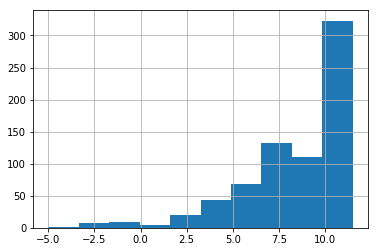

In [92]:
txns[txns['token']=='DAI'].amount.apply(lambda x: np.clip(np.log(x), -5,15)).hist()

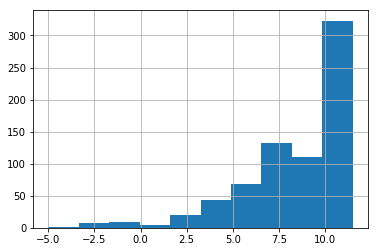

In [93]:
txns[txns['token']=='DAI'].amount.apply(lambda x: np.clip(np.log(x), -5,15)).hist()

In [100]:
ufrom =txns['from'].unique()
uto = txns['to'].unique()

uboth = [val for val in ufrom if val in uto]


In [101]:
len(uboth)/float(len(ufrom)+len(uto)-len(uboth))

0.36607142857142855